<a href="https://colab.research.google.com/github/denisecammarota/tesis-ib/blob/master/DatosCorrReales/Scale_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing against reality matrices and mean orders

## Uploading and processing of real calculated data of correlation and lags 

In [4]:
import pandas as pd
import numpy as np
#copied from Def_TimeCorr_DataAnalysis.ipybn
datos = pd.read_csv('def_lags_provs.csv',sep=",",header=None)
datos2 = pd.read_csv('def_corr_provs.csv',sep=",",header=None)
matriz = datos.to_numpy()
matriz2 = datos2.to_numpy()

FileNotFoundError: ignored

In [ ]:
matrix_real = np.delete(matriz,16,0)
matrix2_real = np.delete(matriz2,16,0)
matrix_real = np.delete(matrix_real,16,1)
matrix2_real = np.delete(matrix2_real,16,1)

In [12]:
orden_provs = ['BA','CABA','CA','CHA','CHU','COR','CB','ER','FO','JU','LP','LR','MZ','MI','NQ','RN','ST','SJ','SL','SC','SF','SDE','TF','TU']

In [ ]:
mean_lags_real = np.mean(matrix2_real,axis=0)
mean_corrs_real = np.mean(matrix_real,axis=0)

# Auxiliary Code for the Models 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
plt.style.use('seaborn')

In [ ]:
def initial_condition(N,n): #corregido a nro de personas
  S = np.zeros(n)
  I = np.zeros(n)
  R = np.zeros(n)
  S[0] = N*0.5 - 1
  I[0] =  1
  S[1:-1] = np.random.uniform(0,N*0.5)
  S[-1] = N*0.5 - np.sum(S[1:-1])
  return S,I,R

In [ ]:
def numbers_with_sum(n, k): #no necesito correccion a nro de personas
    """n numbers with sum k"""
    #https://stackoverflow.com/questions/58023361/generating-multiple-random-integer-number-with-fixed-sum-100-in-numpy-array (modified by me)
    if n == 1:
        return [k]
    if k == 0:
      num = 0
    elif k == 1:
      num = 1
    else:
      num = np.random.randint(1, k)
    return [num] + numbers_with_sum(n - 1, k - num)

In [ ]:
def initial_condition_alt(N,n): #corregido a nro de personas
  S = np.zeros(n)
  I = np.zeros(n)
  R = np.zeros(n)
  N_0 = numbers_with_sum(n,N)
  for i in range(n):
    if N_0[i] != 0:
      I[i] = np.random.randint(0,N_0[i])
      S[i] = N_0[i] - I[i]
    else:
      I[i] = 0
      S[i] = 0
  return S,I,R

In [ ]:
def initial_condition_new(sus,inf,n): #corregido a nro de personas
  S = np.ones(n)*sus
  I = np.zeros(n)
  I[0] = inf
  R = np.zeros(n)
  return S,I,R

In [ ]:
def matrices_sim(n,min,max): #no necesita correccion a nro de personas
  A = np.random.uniform(min,max,size=(n,n))
  A -= np.diag(np.diag(A))
  for i in range(n):
    for j in range(n):
      if j != i:
        A[i,i] -= A[i,j]
  return A

In [ ]:
def matrices_sim_2(n,min,max): #no necesita correccion a nro de personas 
  A = np.random.uniform(min,max,size=(n,n))
  A = (A + A.T)/2 #symmetric matrix as result 
  A -= np.diag(np.diag(A))
  for i in range(n):
    A[i,i] = 0
    for j in range(n):
      if j != i:
        A[i,i] -= A[i,j]
  return A

In [ ]:
def matrices_trivial(n): #no necesita correccion de nro de personas 
  A = np.zeros(shape=(n,n))
  return A

In [ ]:
def SIR_model(y0,t,n,beta,gamma,A):
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  N = X+Y+Z
  aux_X = np.zeros(n)
  aux_Y = np.zeros(n)
  aux_Z = np.zeros(n)
  for i in range(n):
    aux_X_2 = 0
    aux_Y_2 = 0
    aux_Z_2 = 0
    for j in range(n):
        aux_X_2 += A[i,j]*X[j]*(N[i]/N[j])
        aux_Y_2 += A[i,j]*Y[j]*(N[i]/N[j])
        aux_Z_2 += A[i,j]*Z[j]*(N[i]/N[j])
    aux_X[i] = aux_X_2
    aux_Y[i] = aux_Y_2
    aux_Z[i] = aux_Z_2
  dXdt = -beta*X*Y/N + (aux_X)
  dYdt = beta*X*Y/N - gamma*Y + (aux_Y)
  dZdt = gamma*Y + (aux_Z)
  return np.concatenate((dXdt,dYdt,dZdt))

In [ ]:
def SIR_model_2(y0,t,n,beta,gamma,A,B):
  X = y0[0:n]
  Y = y0[n:2*n]
  Z = y0[2*n:]
  N = X+Y+Z
  dXdt = -beta*X*Y/N + N*(A@(X/N))
  dYdt = beta*X*Y/N - gamma*Y + N*(B@(Y/N))
  dZdt = gamma*Y + N*(A@(Z/N))
  return np.concatenate((dXdt,dYdt,dZdt))

In [ ]:
#@title 
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
#@title 
def sign_custom(m):
  m_sign = np.sign(m)
  m_sign[m_sign == 0] = 1
  return m_sign

# SIR Model
In all models, I assume the following set of equations for each patch:

\begin{align}
\frac{dX_i}{dt} = -\frac{\beta X_{i} Y_{i}}{N_i} + \sum_{j} A_{ij} X_{j} \frac{N_i}{N_j} \\
\frac{dY_i}{dt} =  \frac{\beta X_{i} Y_{i}}{N_i} -\gamma Y_{i} + \sum_{j} A_{ij} Y_{j} \frac{N_i}{N_j} \\
\frac{dZ_i}{dt} = \gamma Y_{i} + \sum_{j} A_{ij} Z_{j} \frac{N_i}{N_j}\\
\end{align}

for $i=1,...,n$, assuming there are $n$ different patches.
For keeping the number of people constant in each patch, the following conditions are required:

\begin{align}
\sum_{j} A_{ij} = 0 \\
\end{align}

For simplicity, I assumed that all matrices are equal, just to have less parameters. Later, a different matrix B could be introduced so that it gives less mobility to infected people. Or we could remove this mobility. 

Main reference (used to construct the equations): https://www.sciencedirect.com/science/article/abs/pii/S0025556404000719?via%3Dihub

# Number of people in each province model - real initial condition

In [ ]:
population = np.array([15625084,2890151,367828,1055259,509108,992595,3308876,1235994,530162,673307,318951,333642,1738929,1101593,551266,638645,1214441,681055,432310,273964,3194537,874006,127205,1448188])
orden_provs = ['BA','CABA','CA','CHA','CHU','COR','CB','ER','FO','JU','LP','LR','MZ','MI','NQ','RN','ST','SJ','SL','SC','SF','SDE','TF','TU']
pop_infected = np.array([59,57,0,17,1,3,7,4,0,1,0,1,2,0,2,6,0,0,1,3,4,0,3,2]) #pop infected at day 70 by provinces

In [ ]:
#trying to relate matrix A to the population sizes of each place
n = population.shape[0]
pop_total = np.sum(population)
A_new = np.zeros(shape=(n,n))
for i in range(n):
  for j in range(n):
    A_new[i,j] = 0.0001*(population[i]+population[j])/(pop_total)
for i in range(n):
  A_new[i,i] = 0
  for j in range(n):
    if i != j:
      A_new[i,i] -= A_new[i,j]

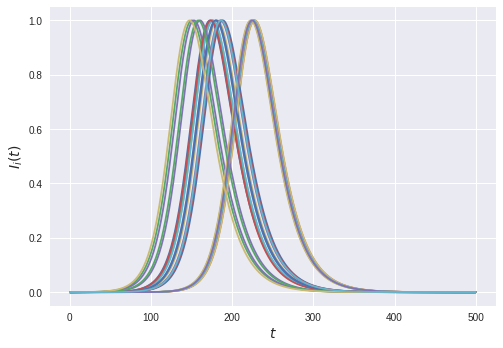

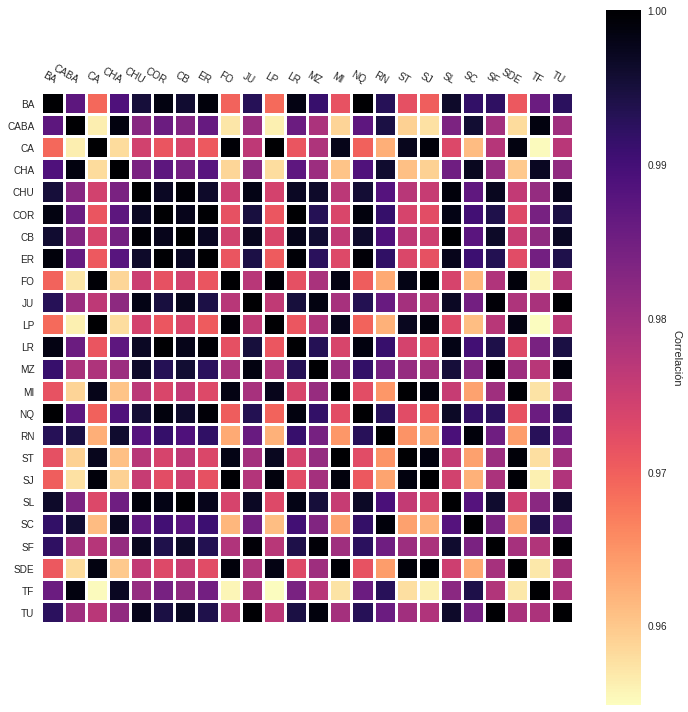

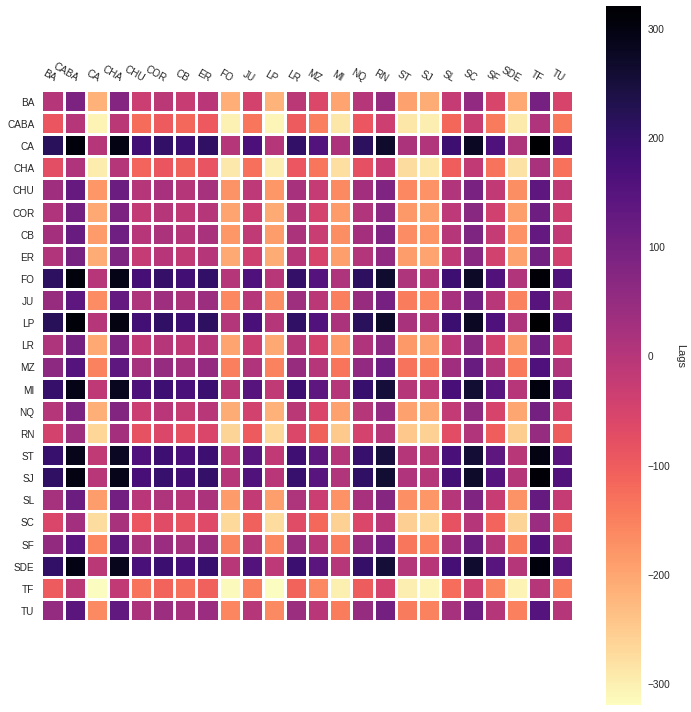

In [ ]:
  n = population.shape[0] #number of regions
  beta = 2*(1./14)
  gamma = 1./14
  I = np.copy(pop_infected)
  S = np.copy(population) - I
  R = np.zeros(n) 
  A = np.copy(A_new)
  tmax = 500
  t = np.linspace(0,tmax,(tmax+1)*4)
  y0 = np.concatenate((S,I,R))
  result = odeint(SIR_model,y0, t, args=(n,beta,gamma,A))
  S = result[:,0:n]
  I = result[:,n:2*n]
  R = result[:,2*n:]
  for i in range(n):
    I[:,i] = I[:,i]/max(I[:,i])
    plt.plot(t,I[:,i])
  plt.ylabel(r'$I_i(t)$',fontsize=14)
  plt.xlabel(r'$t$',fontsize=14)
  #plt.savefig('non_neutral_a_'+str(k)+'.pdf')
  plt.show()
  max_correlations = np.zeros((n,n))
  max_lags = np.zeros((n,n))
  npts = I[:,0].shape[0]
  lags = np.arange(-npts + 1, npts)
  for i in range(n):
    for j in range(n):
      ccov = np.correlate(I[:,i]-I[:,i].mean(),I[:,j]-I[:,j].mean(),mode='full')
      ccor = ccov / (npts * I[:,i].std() * I[:,j].std())
      max_correlations[i,j] = np.max(ccor)
      max_lags[i,j] = lags[np.argmax(ccor)]
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_correlations, orden_provs, orden_provs, ax=ax,
                    cmap="magma_r", cbarlabel="Correlación")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_lags, orden_provs, orden_provs, ax=ax,
                    cmap="magma_r", cbarlabel="Lags")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()

## Mean values of correlation comparison

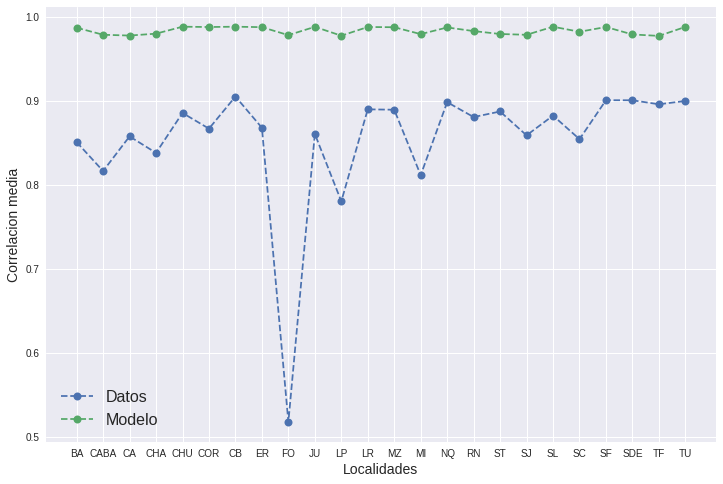

In [ ]:
#comparison by mean values of correlation
f, ax = plt.subplots(figsize=(12,8))
ax.set_xticks(np.arange(len(orden_provs)))
ax.set_xticklabels(orden_provs)
plt.plot(mean_corrs_real,'o--',markersize=8,label='Datos')
plt.plot(np.mean(max_correlations,axis=0),'o--',markersize=8,label='Modelo')
plt.xlabel('Localidades',fontsize=14)
plt.ylabel('Correlacion media',fontsize=14)
plt.legend(fontsize=16)

(0.85, 1.02)

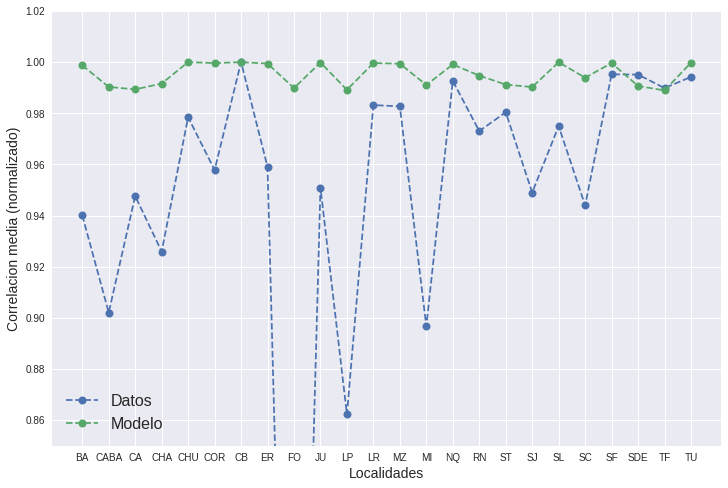

In [ ]:
#comparison by mean values of correlation
f, ax = plt.subplots(figsize=(12,8))
ax.set_xticks(np.arange(len(orden_provs)))
ax.set_xticklabels(orden_provs)
plt.plot(mean_corrs_real/max(mean_corrs_real),'o--',markersize=8,label='Datos')
plt.plot(np.mean(max_correlations,axis=0)/max(np.mean(max_correlations,axis=0)),'o--',markersize=8,label='Modelo')
plt.xlabel('Localidades',fontsize=14)
plt.ylabel('Correlacion media (normalizado)',fontsize=14)
plt.legend(fontsize=16)
plt.ylim((0.85,1.02))

## Mean values of lag comparison

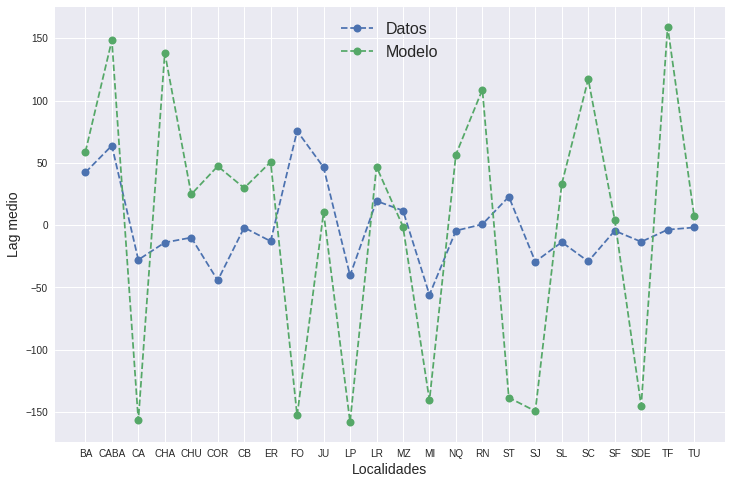

In [ ]:
#comparison by mean values of correlation
f, ax = plt.subplots(figsize=(12,8))
ax.set_xticks(np.arange(len(orden_provs)))
ax.set_xticklabels(orden_provs)
plt.plot(mean_lags_real,'o--',markersize=8,label='Datos')
plt.plot(np.mean(max_lags,axis=0),'o--',markersize=8,label='Modelo')
plt.xlabel('Localidades',fontsize=14)
plt.ylabel('Lag medio',fontsize=14)
plt.legend(fontsize=16)

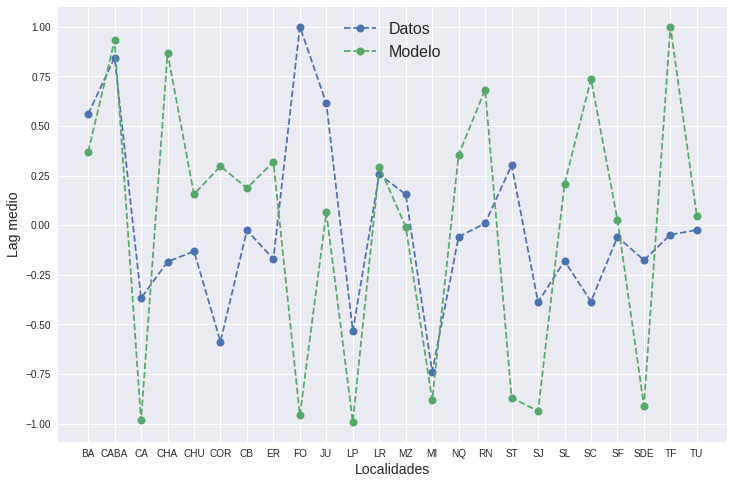

In [ ]:
f, ax = plt.subplots(figsize=(12,8))
ax.set_xticks(np.arange(len(orden_provs)))
ax.set_xticklabels(orden_provs)
plt.plot(mean_lags_real/max(mean_lags_real),'o--',markersize=8,label='Datos')
plt.plot(np.mean(max_lags,axis=0)/max(np.mean(max_lags,axis=0)),'o--',markersize=8,label='Modelo')
plt.xlabel('Localidades',fontsize=14)
plt.ylabel('Lag medio',fontsize=14)
plt.legend(fontsize=16)

## Correlation matrices comparison

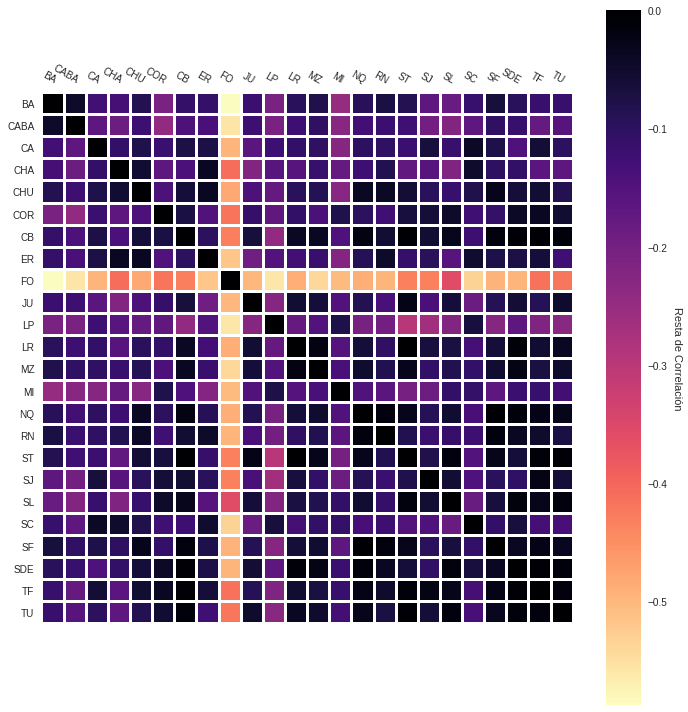

In [ ]:
dif_corrs = matrix_real - max_correlations
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(dif_corrs, orden_provs, orden_provs, ax=ax,
                    cmap="magma_r", cbarlabel="Resta de Correlación")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

plt.grid()
fig.tight_layout()
plt.show()


In [ ]:
dif_corrs[8,:] = np.nan
dif_corrs[:,8] = np.nan

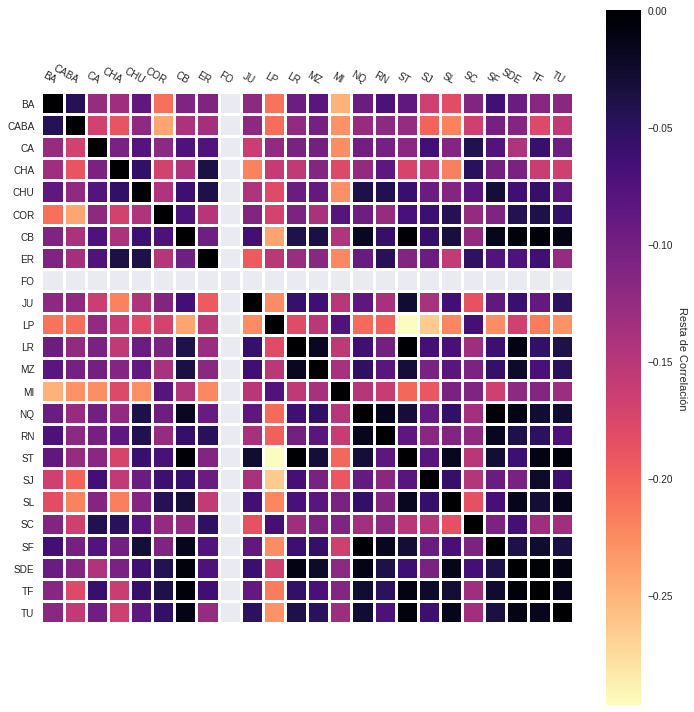

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(dif_corrs, orden_provs, orden_provs, ax=ax,
                    cmap="magma_r", cbarlabel="Resta de Correlación")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

plt.grid()
fig.tight_layout()
plt.show()


## Lags matrices comparison

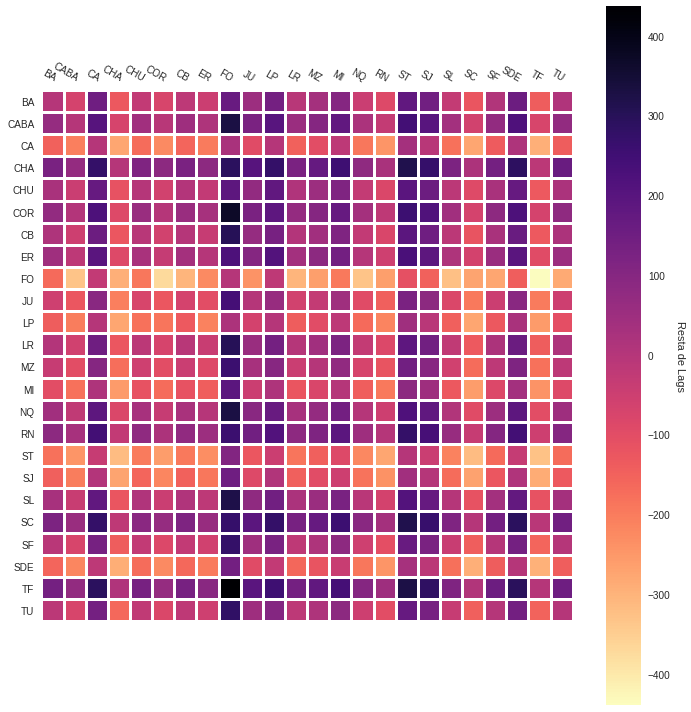

In [ ]:
dif_lags = matrix2_real - max_lags
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(dif_lags, orden_provs, orden_provs, ax=ax,
                    cmap="magma_r", cbarlabel="Resta de Lags")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

plt.grid()
fig.tight_layout()
plt.show()

In [ ]:
dif_lags[8,:] = np.nan
dif_lags[:,8] = np.nan

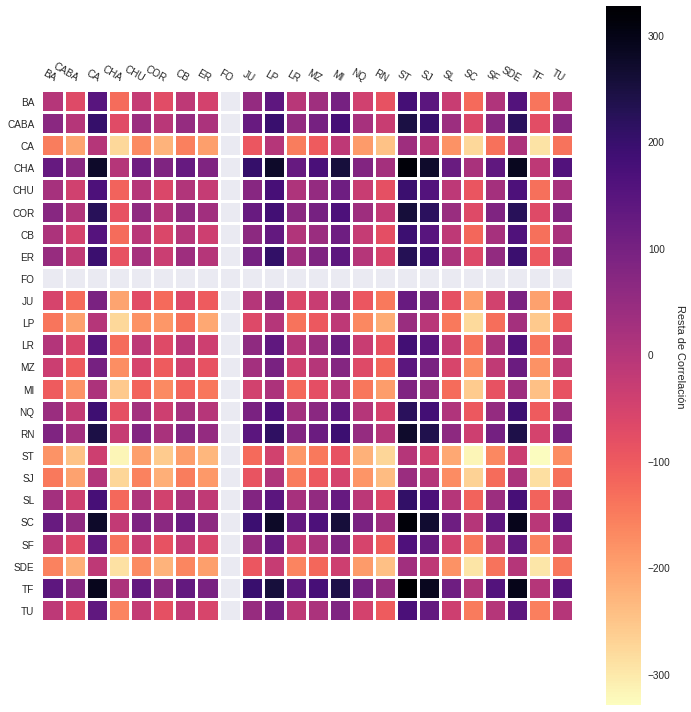

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

im, cbar = heatmap(dif_lags, orden_provs, orden_provs, ax=ax,
                    cmap="magma_r", cbarlabel="Resta de Correlación")
#texts = annotate_heatmap(im, valfmt="{x:.1f} t")

plt.grid()
fig.tight_layout()
plt.show()


# Distances between places model - real initial condition

In [16]:
orden_falso = ['CABA','CB','COR','FO','BA','LR','MZ','NQ','ER','MI','CHU','CHA','SC','CA','TU','ST','SJ','SL','JU','SF','LP','SDE','TF','RN']

In [17]:
import numpy as np
distancia = np.zeros((24,24))

In [18]:
distancia[0,:] = np.array([1,715,940,1191,61,1150,1050,1158,480,1040,1455,1023,2635,1155,1203,1510,1110,790,1543,478,620,1043,3228,960])
distancia[1,1:] = np.array([1,898,1043,757,435,670,1137,361,1213,1455,875,3635,440,590,897,500,420,930,330,600,430,3228,1194])
distancia[2,2:] = np.array([1,191,978,993,1565,1989,590,315,2187,23,3367,845,791,803,1398,1318,883,568,1378,633,3960,2046])
distancia[3,3:] = np.array([1,1253,1136,1710,2060,744,506,2378,168,3558,988,936,948,1543,1463,960,713,1523,776,4151,2117])
distancia[4,4:] = np.array([1,1189,1152,1197,555,1061,1414,996,2551,1188,1309,1614,1213,894,1645,527,670,1184,3132,957])
distancia[5,5:] = np.array([1,617,1472,796,1308,1890,970,3070,156,388,695,450,550,770,765,1035,360,3663,1629])
distancia[6,6:] = np.array([1,855,916,1925,1620,1587,2800,773,1005,1227,167,260,1345,885,765,977,3393,1359])
distancia[7,7:] = np.array([1,1378,2198,750,2012,1930,1588,1860,2082,1022,883,2200,1347,537,1567,2523,660])
distancia[8,8:] = np.array([1,820,1696,576,2876,801,798,1105,861,656,1138,31,841,1638,3469,1435])
distancia[9,9:] = np.array([1,2495,338,3675,1160,1106,1118,1758,1633,1198,883,1660,948,4268,2000])
distancia[10,10:] = np.array([1,2210,1180,1895,2045,2352,1680,1360,2385,1665,855,1885,1773,495])
distancia[11,11:] = np.array([1,3390,822,765,780,1420,1295,860,545,1475,610,3983,2069])
distancia[12,12:] = np.array([1,3075,3225,3532,2860,2540,3565,2845,2035,3065,593,1675])
distancia[13,13:] = np.array([1,232,539,606,705,572,770,1040,212,3668,1634])
distancia[14,14:] = np.array([1,307,838,938,340,767,1190,160,3818,1784])
distancia[15,15:] = np.array([1,1145,1245,99,1074,1497,467,4125,2091])
distancia[16,16:] = np.array([1,320,1220,830,825,810,3435,1419])
distancia[17,17:] = np.array([1,1320,625,505,850,3133,1099])
distancia[18,18:] = np.array([1,1107,1530,500,4158,2124])
distancia[19,19:] = np.array([1,810,607,3438,1404])
distancia[20,20:] = np.array([1,1030,2628,594])
distancia[21,21:] = np.array([1,3658,1624])
distancia[22,22:] = np.array([1,2268])
distancia[23,23:] = np.array([1])

In [19]:
distancia_falsa = distancia + distancia.T

In [20]:
np.fill_diagonal(distancia_falsa,1)

In [21]:
distancia_falsa

array([[1.000e+00, 7.150e+02, 9.400e+02, 1.191e+03, 6.100e+01, 1.150e+03,
        1.050e+03, 1.158e+03, 4.800e+02, 1.040e+03, 1.455e+03, 1.023e+03,
        2.635e+03, 1.155e+03, 1.203e+03, 1.510e+03, 1.110e+03, 7.900e+02,
        1.543e+03, 4.780e+02, 6.200e+02, 1.043e+03, 3.228e+03, 9.600e+02],
       [7.150e+02, 1.000e+00, 8.980e+02, 1.043e+03, 7.570e+02, 4.350e+02,
        6.700e+02, 1.137e+03, 3.610e+02, 1.213e+03, 1.455e+03, 8.750e+02,
        3.635e+03, 4.400e+02, 5.900e+02, 8.970e+02, 5.000e+02, 4.200e+02,
        9.300e+02, 3.300e+02, 6.000e+02, 4.300e+02, 3.228e+03, 1.194e+03],
       [9.400e+02, 8.980e+02, 1.000e+00, 1.910e+02, 9.780e+02, 9.930e+02,
        1.565e+03, 1.989e+03, 5.900e+02, 3.150e+02, 2.187e+03, 2.300e+01,
        3.367e+03, 8.450e+02, 7.910e+02, 8.030e+02, 1.398e+03, 1.318e+03,
        8.830e+02, 5.680e+02, 1.378e+03, 6.330e+02, 3.960e+03, 2.046e+03],
       [1.191e+03, 1.043e+03, 1.910e+02, 1.000e+00, 1.253e+03, 1.136e+03,
        1.710e+03, 2.060e+03, 7.440

In [22]:
#reacomodamos las matrices de distancias y distancias reales
#tenemos orden_provs y orden_falsos
distancia_real = np.zeros((24,24))
for i in range(24):
  n_p1 = orden_provs[i]
  for j in range(24):
    n_p2 = orden_provs[j]
    n_p1_lista2 = orden_falso.index(n_p1)
    n_p2_lista2 = orden_falso.index(n_p2)
    distancia_real[i,j] = distancia_falsa[n_p1_lista2,n_p2_lista2]

In [ ]:
population = 

## Beginning in CABA and BA 

In [ ]:
#trying to relate matrix A to the population sizes of each place
n = population.shape[0]
pop_total = np.sum(population)
pop_infected = np.array([57,0,0,0,59,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) #pop infected at day 70 by provinces #CABA 57 BAIRES 59
A_new = np.zeros(shape=(n,n))
for i in range(n):
  for j in range(n):
    A_new[i,j] = 0.01*(population[i]+population[j])/(pop_total)*(1/distancia_real[i,j])
for i in range(n):
  A_new[i,i] = 0
  for j in range(n):
    if i != j:
      A_new[i,i] -= A_new[i,j]

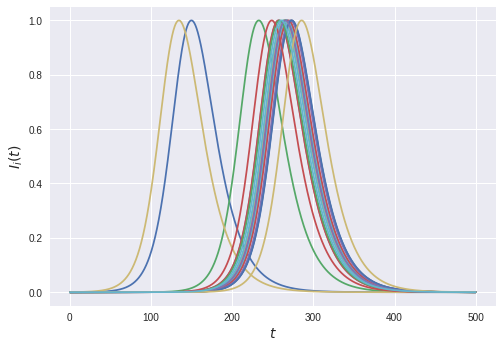

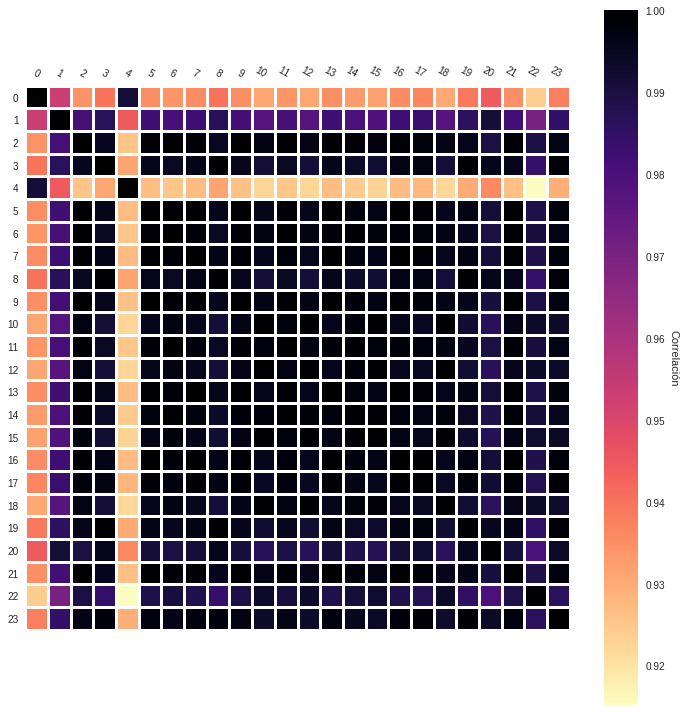

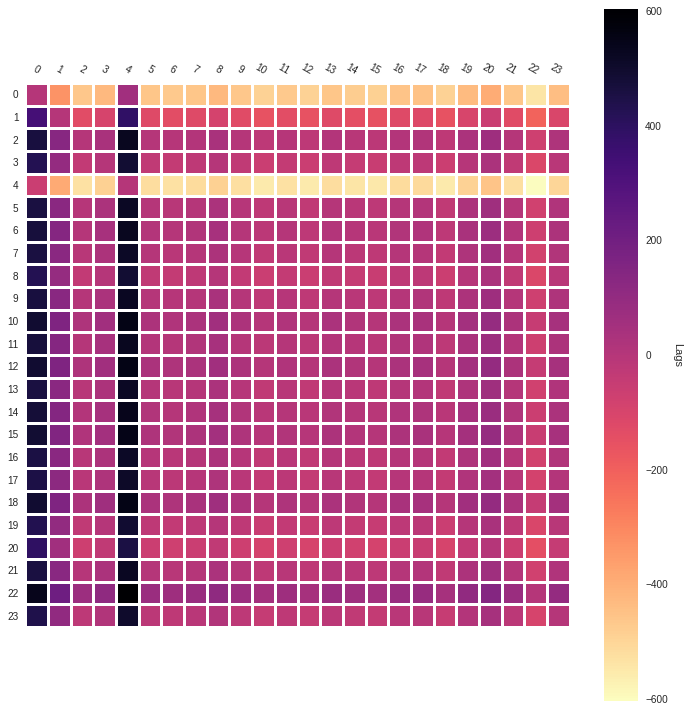

In [ ]:
  n = population.shape[0] #number of regions
  beta = 2*(1./14)
  gamma = 1./14
  I = np.copy(pop_infected)
  S = np.copy(population) - I
  R = np.zeros(n) 
  A = np.copy(A_new)
  tmax = 500
  t = np.linspace(0,tmax,(tmax+1)*4)
  y0 = np.concatenate((S,I,R))
  result = odeint(SIR_model,y0, t, args=(n,beta,gamma,A))
  S = result[:,0:n]
  I = result[:,n:2*n]
  R = result[:,2*n:]
  for i in range(n):
    I[:,i] = I[:,i]/max(I[:,i])
    plt.plot(t,I[:,i])
  plt.ylabel(r'$I_i(t)$',fontsize=14)
  plt.xlabel(r'$t$',fontsize=14)
  #plt.savefig('non_neutral_a_'+str(k)+'.pdf')
  plt.show()
  max_correlations = np.zeros((n,n))
  max_lags = np.zeros((n,n))
  npts = I[:,0].shape[0]
  lags = np.arange(-npts + 1, npts)
  for i in range(n):
    for j in range(n):
      ccov = np.correlate(I[:,i]-I[:,i].mean(),I[:,j]-I[:,j].mean(),mode='full')
      ccor = ccov / (npts * I[:,i].std() * I[:,j].std())
      max_correlations[i,j] = np.max(ccor)
      max_lags[i,j] = lags[np.argmax(ccor)]
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_correlations, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Correlación")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_lags, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Lags")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()

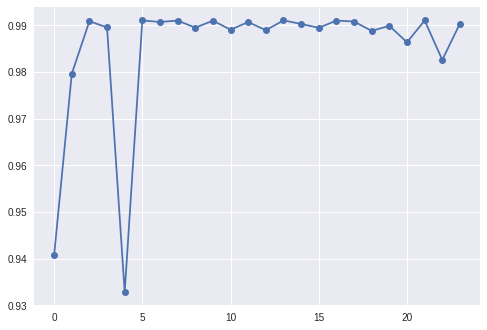

In [ ]:
plt.plot(np.mean(max_correlations,axis=0),'-o')

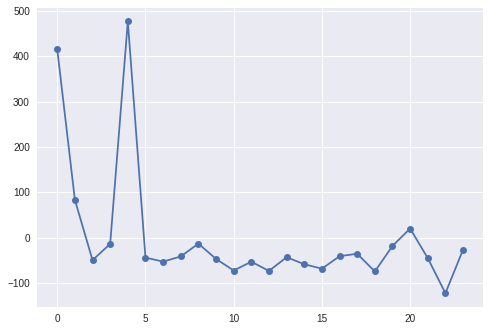

In [ ]:
plt.plot(np.mean(max_lags,axis=0),'-o')

## Beginning in CABA, BA, ST and JY

In [ ]:
#trying to relate matrix A to the population sizes of each place
n = population.shape[0]
pop_total = np.sum(population)
pop_infected = np.array([57,0,0,0,59,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0]) #pop infected at day 70 by provinces #CABA 57 BAIRES 59
A_new = np.zeros(shape=(n,n))
for i in range(n):
  for j in range(n):
    A_new[i,j] = 0.1*(population[i]+population[j])/(pop_total)*(1/distancia_real[i,j])
for i in range(n):
  A_new[i,i] = 0
  for j in range(n):
    if i != j:
      A_new[i,i] -= A_new[i,j]

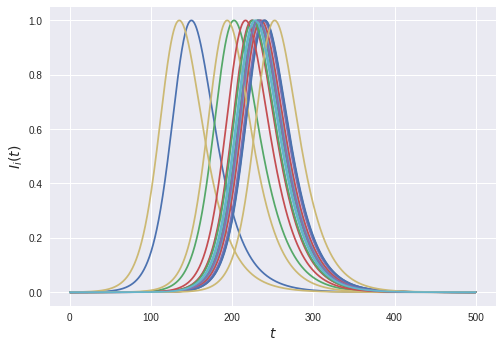

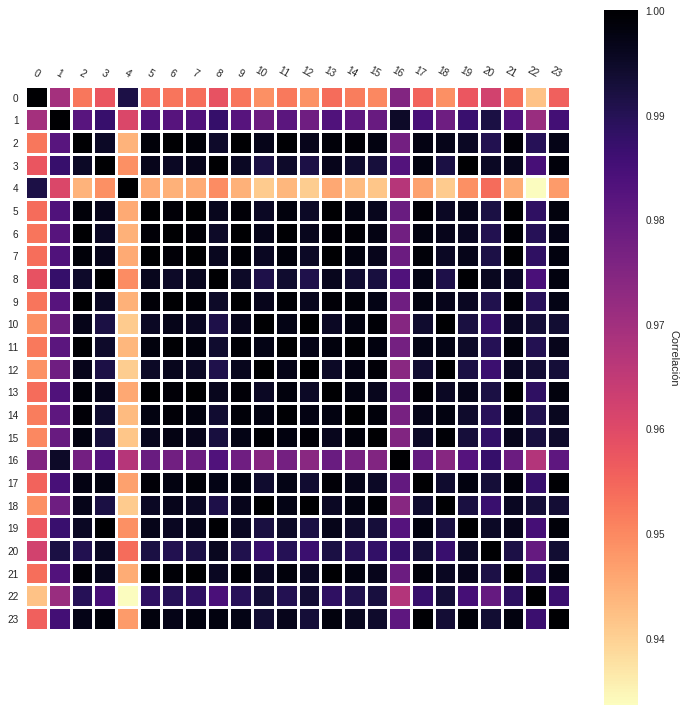

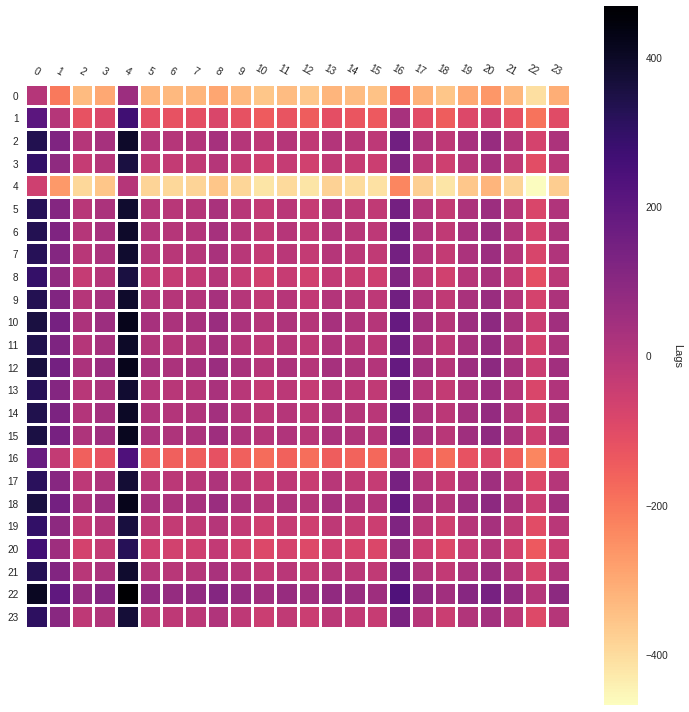

In [ ]:
  n = population.shape[0] #number of regions
  beta = 2*(1./14)
  gamma = 1./14
  I = np.copy(pop_infected)
  S = np.copy(population) - I
  R = np.zeros(n) 
  A = np.copy(A_new)
  tmax = 500
  t = np.linspace(0,tmax,(tmax+1)*4)
  y0 = np.concatenate((S,I,R))
  result = odeint(SIR_model,y0, t, args=(n,beta,gamma,A))
  S = result[:,0:n]
  I = result[:,n:2*n]
  R = result[:,2*n:]
  for i in range(n):
    I[:,i] = I[:,i]/max(I[:,i])
    plt.plot(t,I[:,i])
  plt.ylabel(r'$I_i(t)$',fontsize=14)
  plt.xlabel(r'$t$',fontsize=14)
  #plt.savefig('non_neutral_a_'+str(k)+'.pdf')
  plt.show()
  max_correlations = np.zeros((n,n))
  max_lags = np.zeros((n,n))
  npts = I[:,0].shape[0]
  lags = np.arange(-npts + 1, npts)
  for i in range(n):
    for j in range(n):
      ccov = np.correlate(I[:,i]-I[:,i].mean(),I[:,j]-I[:,j].mean(),mode='full')
      ccor = ccov / (npts * I[:,i].std() * I[:,j].std())
      max_correlations[i,j] = np.max(ccor)
      max_lags[i,j] = lags[np.argmax(ccor)]
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_correlations, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Correlación")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_lags, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Lags")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()

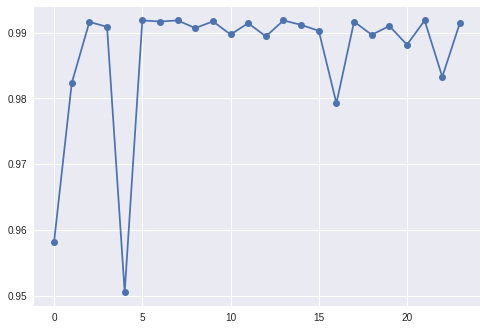

In [ ]:
plt.plot(np.mean(max_correlations,axis=0),'-o')

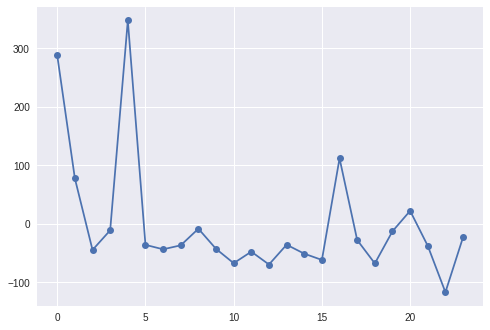

In [ ]:
plt.plot(np.mean(max_lags,axis=0),'-o')

## Beginning initial conditions

In [ ]:
#trying to relate matrix A to the population sizes of each place
n = population.shape[0]
pop_total = np.sum(population)
pop_infected = np.array([57,7,3,0,59,1,2,2,4,0,1,17,3,0,2,0,0,1,1,4,0,0,3,6]) #pop infected at day 70 by provinces #CABA 57 BAIRES 59
A_new = np.zeros(shape=(n,n))
for i in range(n):
  for j in range(n):
    A_new[i,j] = 0.0001*(population[i]+population[j])/(pop_total)*(1/distancia_real[i,j])
for i in range(n):
  A_new[i,i] = 0
  for j in range(n):
    if i != j:
      A_new[i,i] -= A_new[i,j]

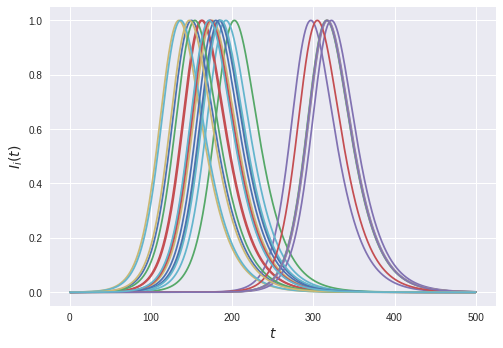

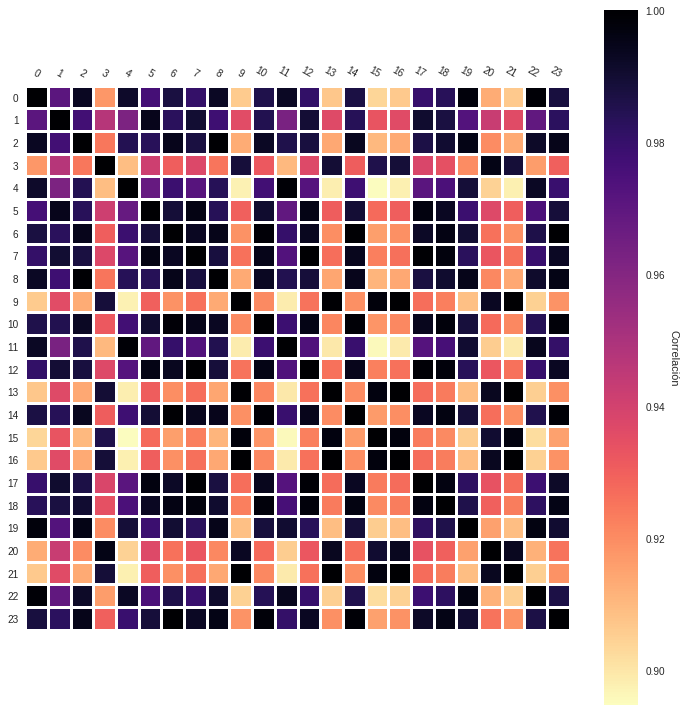

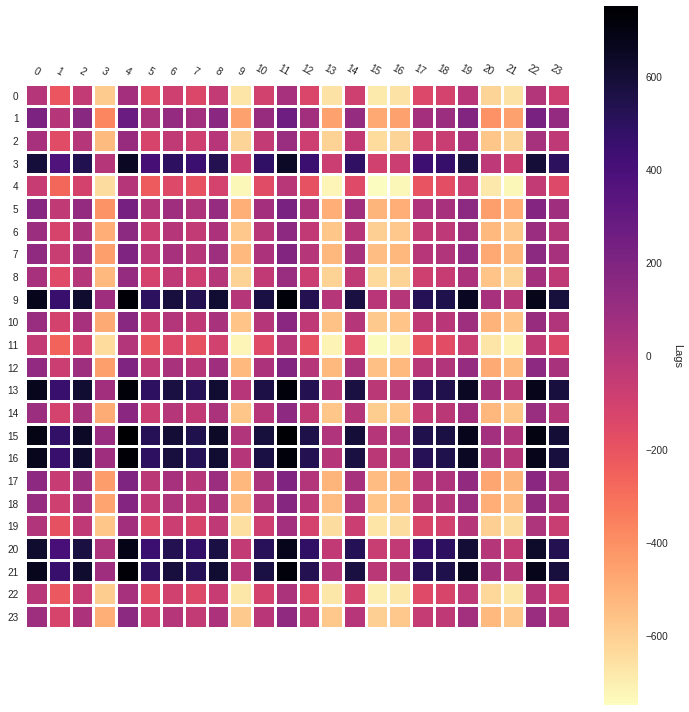

In [ ]:
  n = population.shape[0] #number of regions
  beta = 2*(1./14)
  gamma = 1./14
  I = np.copy(pop_infected)
  S = np.copy(population) - I
  R = np.zeros(n) 
  A = np.copy(A_new)
  tmax = 500
  t = np.linspace(0,tmax,(tmax+1)*4)
  y0 = np.concatenate((S,I,R))
  result = odeint(SIR_model,y0, t, args=(n,beta,gamma,A))
  S = result[:,0:n]
  I = result[:,n:2*n]
  R = result[:,2*n:]
  for i in range(n):
    I[:,i] = I[:,i]/max(I[:,i])
    plt.plot(t,I[:,i])
  plt.ylabel(r'$I_i(t)$',fontsize=14)
  plt.xlabel(r'$t$',fontsize=14)
  #plt.savefig('non_neutral_a_'+str(k)+'.pdf')
  plt.show()
  max_correlations = np.zeros((n,n))
  max_lags = np.zeros((n,n))
  npts = I[:,0].shape[0]
  lags = np.arange(-npts + 1, npts)
  for i in range(n):
    for j in range(n):
      ccov = np.correlate(I[:,i]-I[:,i].mean(),I[:,j]-I[:,j].mean(),mode='full')
      ccor = ccov / (npts * I[:,i].std() * I[:,j].std())
      max_correlations[i,j] = np.max(ccor)
      max_lags[i,j] = lags[np.argmax(ccor)]
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_correlations, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Correlación")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_lags, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Lags")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()

### Mean values of correlation comparison

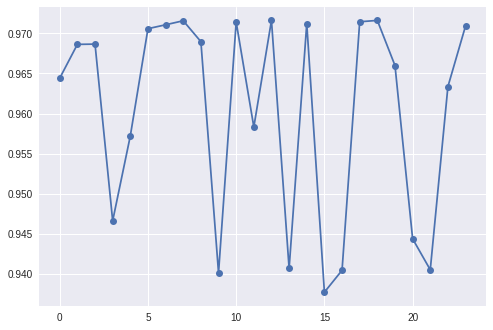

In [ ]:
plt.plot(np.mean(max_correlations,axis=0),'-o')

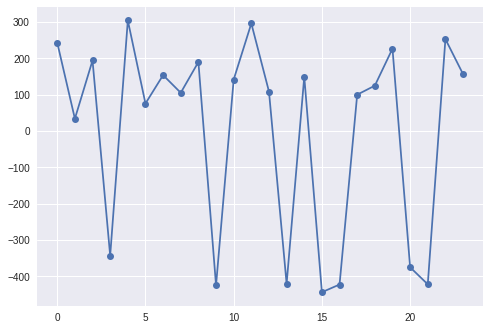

In [ ]:
plt.plot(np.mean(max_lags,axis=0),'-o')

# Distances between places model - false initial condition

## Beginning in CABA and BA

In [ ]:
#trying to relate matrix A to the population sizes of each place
n = population.shape[0]
pop_total = np.sum(population)
pop_infected = np.array([50,0,0,0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) #pop infected at day 70 by provinces #CABA 57 BAIRES 59
A_new = np.zeros(shape=(n,n))
for i in range(n):
  for j in range(n):
    A_new[i,j] = 0.01*(population[i]+population[j])/(pop_total)*(1/distancia_real[i,j])
for i in range(n):
  A_new[i,i] = 0
  for j in range(n):
    if i != j:
      A_new[i,i] -= A_new[i,j]

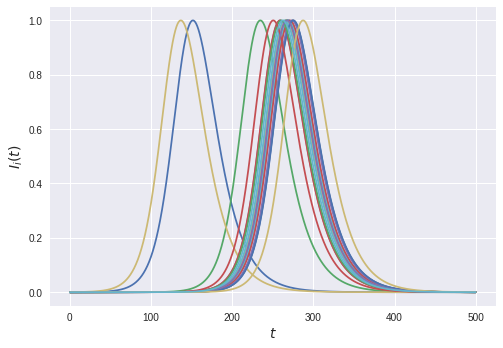

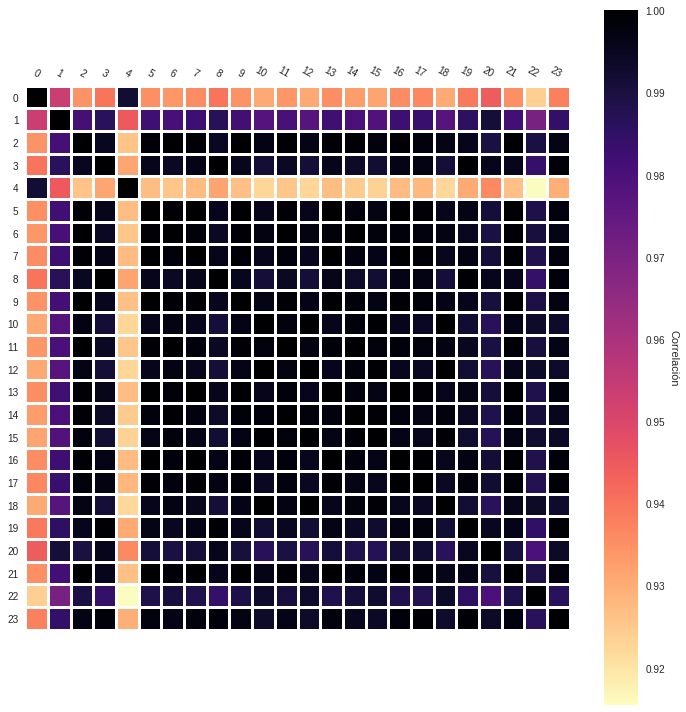

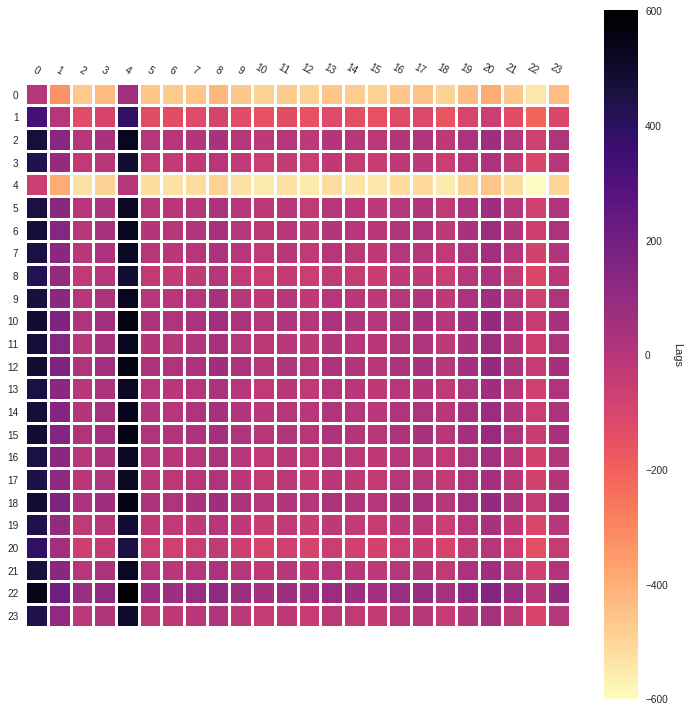

In [ ]:
  n = population.shape[0] #number of regions
  beta = 2*(1./14)
  gamma = 1./14
  I = np.copy(pop_infected)
  S = np.copy(population) - I
  R = np.zeros(n) 
  A = np.copy(A_new)
  tmax = 500
  t = np.linspace(0,tmax,(tmax+1)*4)
  y0 = np.concatenate((S,I,R))
  result = odeint(SIR_model,y0, t, args=(n,beta,gamma,A))
  S = result[:,0:n]
  I = result[:,n:2*n]
  R = result[:,2*n:]
  for i in range(n):
    I[:,i] = I[:,i]/max(I[:,i])
    plt.plot(t,I[:,i])
  plt.ylabel(r'$I_i(t)$',fontsize=14)
  plt.xlabel(r'$t$',fontsize=14)
  #plt.savefig('non_neutral_a_'+str(k)+'.pdf')
  plt.show()
  max_correlations = np.zeros((n,n))
  max_lags = np.zeros((n,n))
  npts = I[:,0].shape[0]
  lags = np.arange(-npts + 1, npts)
  for i in range(n):
    for j in range(n):
      ccov = np.correlate(I[:,i]-I[:,i].mean(),I[:,j]-I[:,j].mean(),mode='full')
      ccor = ccov / (npts * I[:,i].std() * I[:,j].std())
      max_correlations[i,j] = np.max(ccor)
      max_lags[i,j] = lags[np.argmax(ccor)]
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_correlations, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Correlación")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_lags, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Lags")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()

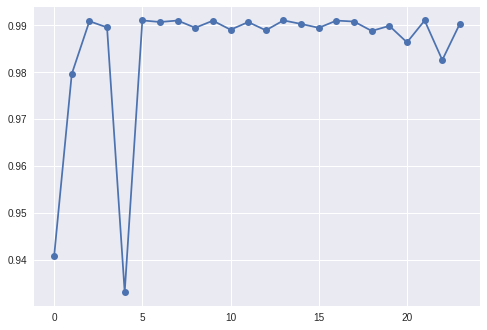

In [ ]:
plt.plot(np.mean(max_correlations,axis=0),'-o')

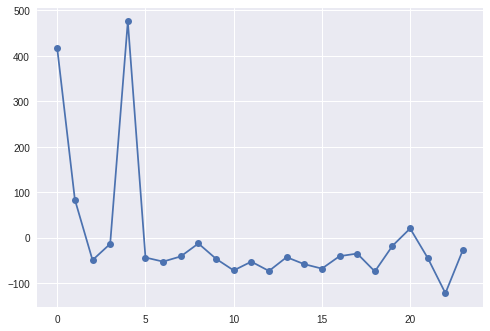

In [ ]:
plt.plot(np.mean(max_lags,axis=0),'-o')

## Beginning in CABA, BA, ST and JY

In [ ]:
#trying to relate matrix A to the population sizes of each place
n = population.shape[0]
pop_total = np.sum(population)
pop_infected = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]) #pop infected at day 70 by provinces #CABA 57 BAIRES 59
pop_infected[0] = 50
pop_infected[4] = 50
pop_infected[15] = 50
pop_infected[18] = 50
A_new = np.zeros(shape=(n,n))
for i in range(n):
  for j in range(n):
    A_new[i,j] = 0.01*(population[i]+population[j])/(pop_total)*(1/distancia_real[i,j])
for i in range(n):
  A_new[i,i] = 0
  for j in range(n):
    if i != j:
      A_new[i,i] -= A_new[i,j]

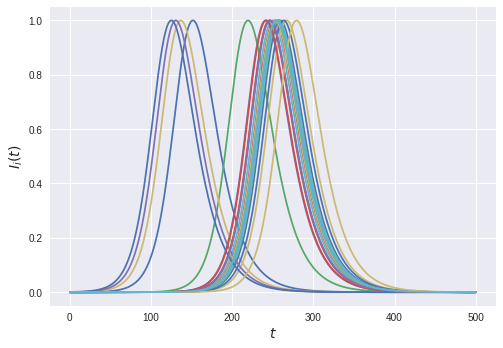

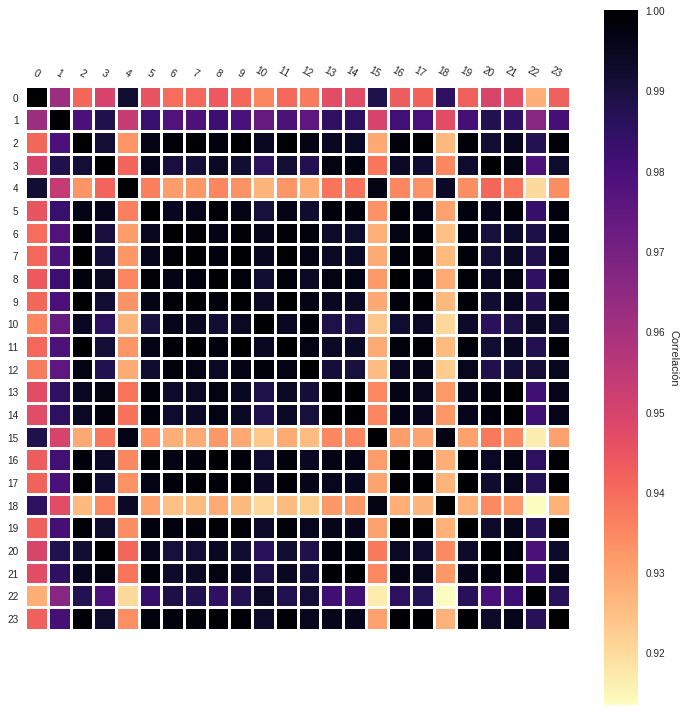

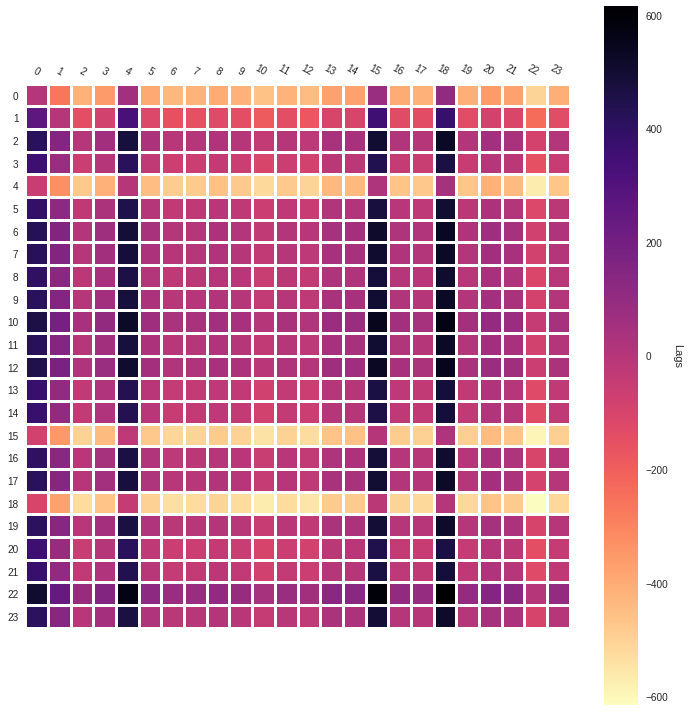

In [ ]:
  n = population.shape[0] #number of regions
  beta = 2*(1./14)
  gamma = 1./14
  I = np.copy(pop_infected)
  S = np.copy(population) - I
  R = np.zeros(n) 
  A = np.copy(A_new)
  tmax = 500
  t = np.linspace(0,tmax,(tmax+1)*4)
  y0 = np.concatenate((S,I,R))
  result = odeint(SIR_model,y0, t, args=(n,beta,gamma,A))
  S = result[:,0:n]
  I = result[:,n:2*n]
  R = result[:,2*n:]
  for i in range(n):
    I[:,i] = I[:,i]/max(I[:,i])
    plt.plot(t,I[:,i])
  plt.ylabel(r'$I_i(t)$',fontsize=14)
  plt.xlabel(r'$t$',fontsize=14)
  #plt.savefig('non_neutral_a_'+str(k)+'.pdf')
  plt.show()
  max_correlations = np.zeros((n,n))
  max_lags = np.zeros((n,n))
  npts = I[:,0].shape[0]
  lags = np.arange(-npts + 1, npts)
  for i in range(n):
    for j in range(n):
      ccov = np.correlate(I[:,i]-I[:,i].mean(),I[:,j]-I[:,j].mean(),mode='full')
      ccor = ccov / (npts * I[:,i].std() * I[:,j].std())
      max_correlations[i,j] = np.max(ccor)
      max_lags[i,j] = lags[np.argmax(ccor)]
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_correlations, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Correlación")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()
  fig, ax = plt.subplots(figsize=(10,10))

  im, cbar = heatmap(max_lags, range(n), range(n), ax=ax,
                    cmap="magma_r", cbarlabel="Lags")
  #texts = annotate_heatmap(im, valfmt="{x:.1f} t")

  plt.grid()
  fig.tight_layout()
  plt.show()

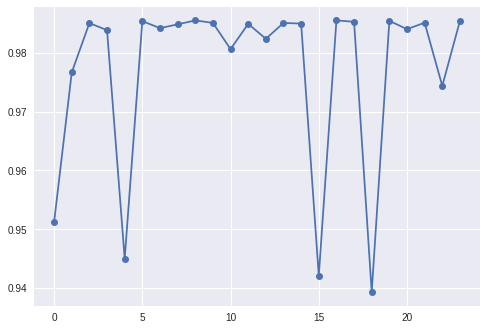

In [ ]:
plt.plot(np.mean(max_correlations,axis=0),'-o')

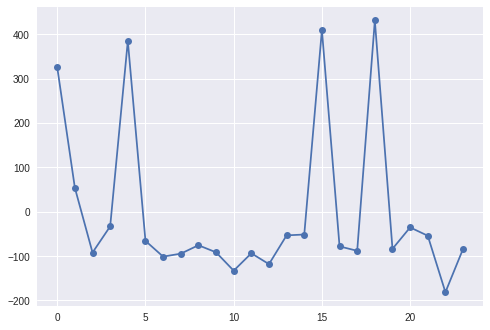

In [ ]:
plt.plot(np.mean(max_lags,axis=0),'-o')